# MTH 563
Project task 5

Student C

#### (Please open in Colab) The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The subset of the dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest (ROI).

In [103]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import networkx as nx
from networkx.algorithms import community

In [104]:
# Necessary for visualization
!pip install nilearn --quiet
from nilearn import plotting, datasets

In [105]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [106]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.


They also separately provide some potentially useful behavioral covariate information.

In [107]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [108]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [109]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [110]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [111]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [112]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [113]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [114]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

In [115]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [116]:
timeseries = load_timeseries(subject=0, name="rest", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [117]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest")
  timeseries_rest.append(ts_concat)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

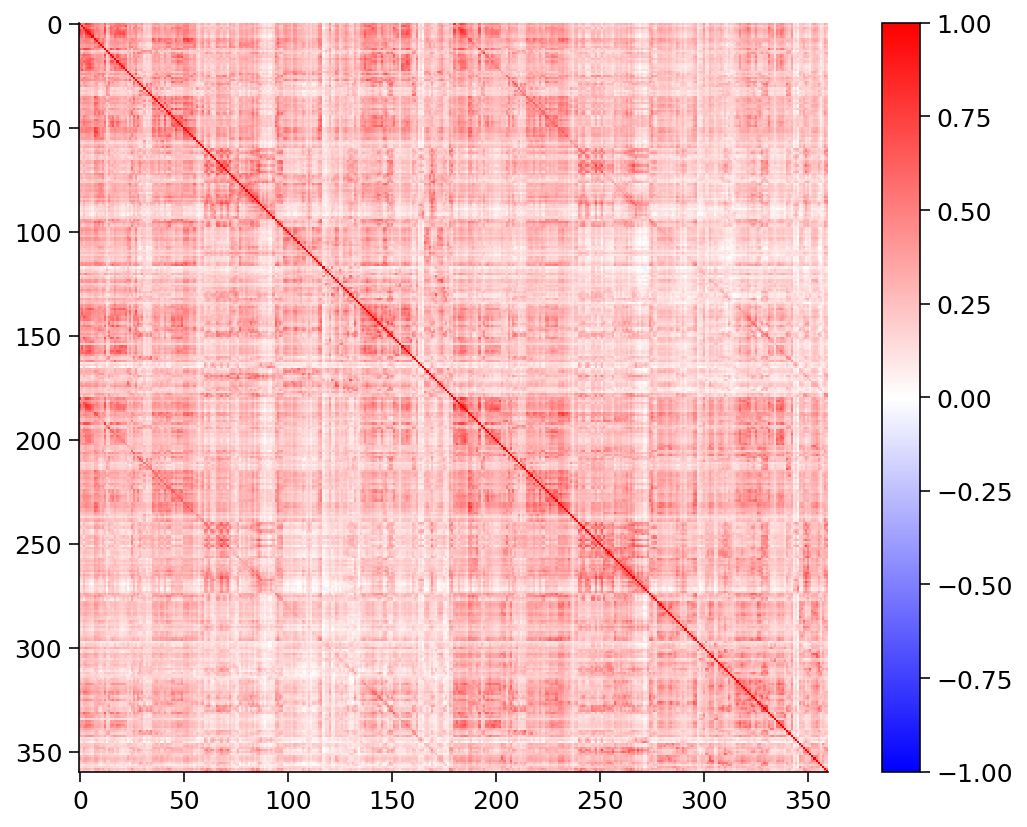

In [118]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

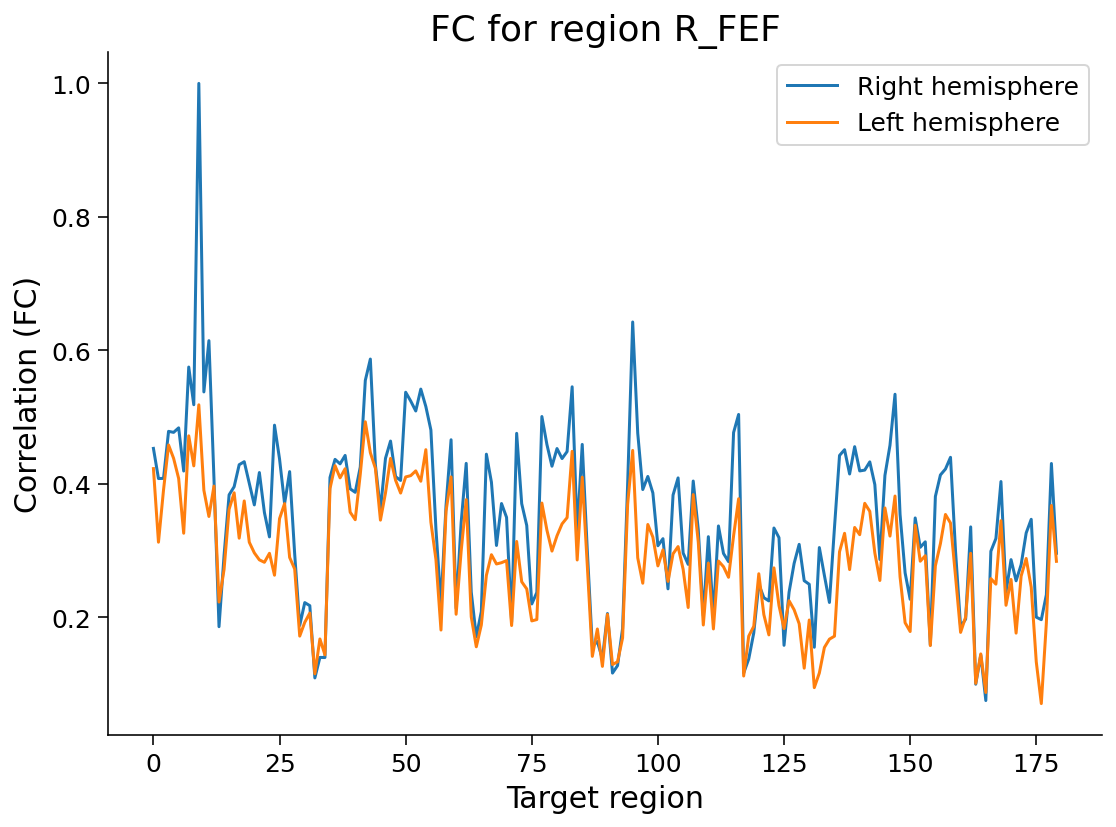

In [119]:
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

Threshold the correlation matrix to produce a connectome, and plot it:

In [120]:
plotting.view_connectome(group_fc, atlas["coords"], edge_threshold="99%")

In [121]:
def get_adjacency_matrix_on_threshold(adjacency_matrix, threshold=None):
    adjacency_matrix = np.nan_to_num(adjacency_matrix, copy=True)
    if threshold is not None:
      adjacency_matrix[np.abs(adjacency_matrix) <= threshold] = 0
    return adjacency_matrix


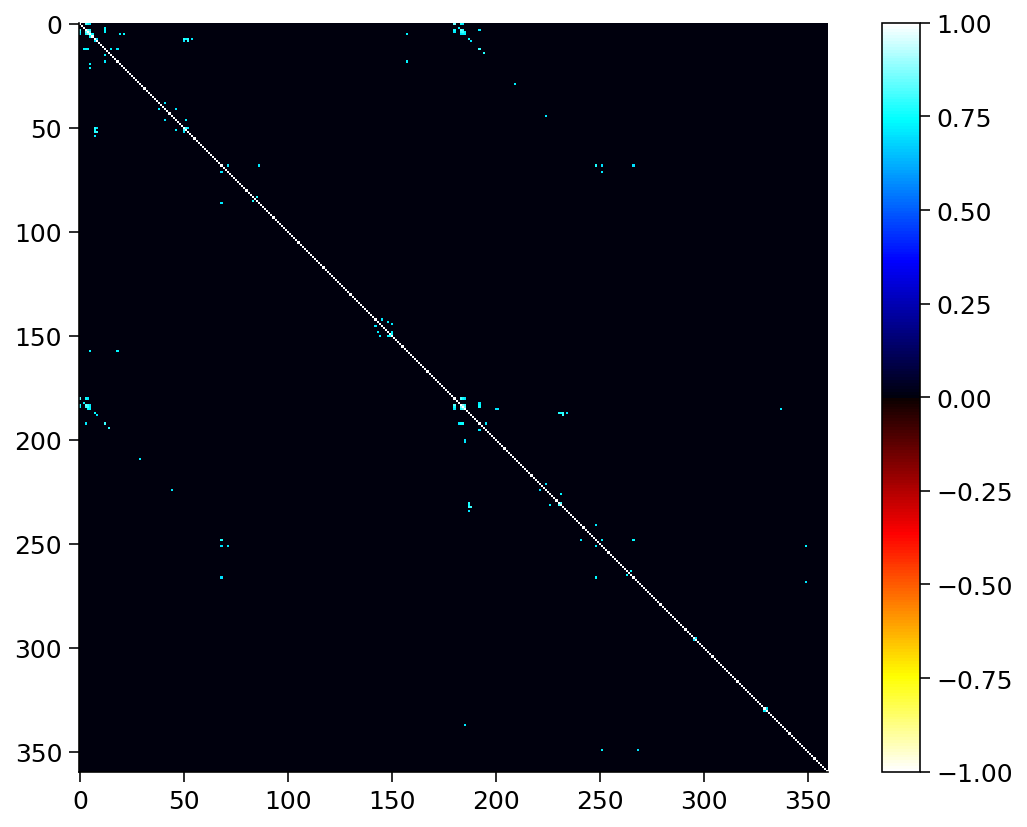

In [122]:
plot_matrix = get_adjacency_matrix_on_threshold(group_fc, threshold = 0.7)
plt.imshow(plot_matrix, interpolation="none", cmap="cold_hot_r", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

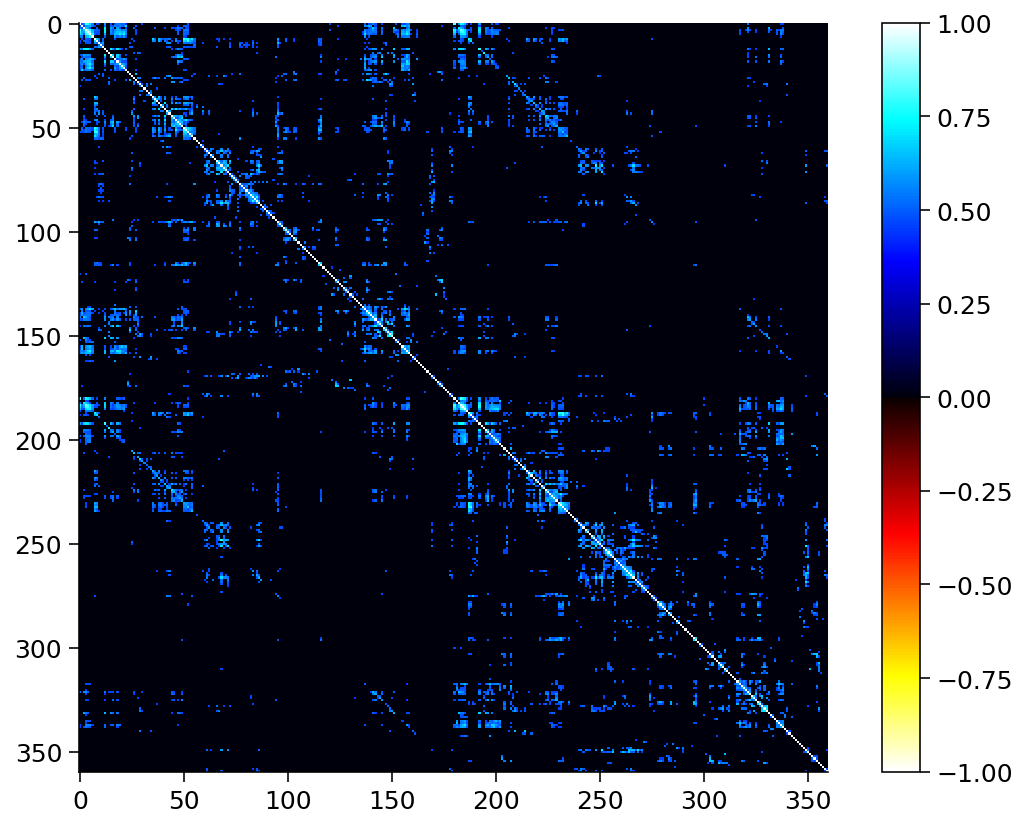

In [123]:
plot_matrix = get_adjacency_matrix_on_threshold(group_fc, threshold = 0.45)
plt.imshow(plot_matrix, interpolation="none", cmap="cold_hot_r", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

## Exploring and analyzing network

In [124]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from operator import itemgetter
import json 

In [125]:
plot_matrix = get_adjacency_matrix_on_threshold(group_fc, threshold = 0.7)
np.fill_diagonal(plot_matrix,0)
G_fc = nx.from_numpy_matrix(plot_matrix)
print(nx.info(G_fc))
# region_info['network'].shape

Name: 
Type: Graph
Number of nodes: 360
Number of edges: 90
Average degree:   0.5000


In [126]:
# Centrality. Which nodes/regions are the most important
betweenness_dict = nx.betweenness_centrality(G_fc) # Run betweenness centrality, looks at all the shortest paths that pass through a particular node 
eigenvector_dict = nx.eigenvector_centrality(G_fc) # Run eigenvector centrality

# Assign each to an attribute in the network
nx.set_node_attributes(G_fc, betweenness_dict, 'betweenness')
nx.set_node_attributes(G_fc, eigenvector_dict, 'eigenvector')

# sort betweenness (or eigenvector) centrality
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

# print("Top 10 nodes by betweenness centrality:")
# for b in sorted_betweenness[:10]:
#     print(b)

print("Top 10 nodes by betweenness centrality:")
top_betweenness = sorted_betweenness[:10]
for e in top_betweenness:
    network = region_info['network'][e[0]]
    # name = region_info["name"][e[0]]
    print("Name:", network,"| Number:",e[0],"| Betweenness Centrality:", e[1])
print("Top 10 nodes by eigenvector centrality:")
top_eigenvector = sorted_eigenvector[:10]
for e in top_eigenvector:
    network = region_info['network'][e[0]]
    # name = region_info["name"][e[0]]
    print("Name:", network,"| Number:",e[0],"| Eigenvector Centrality:", e[1])
  

Top 10 nodes by betweenness centrality:
Name: Visual2 | Number: 5 | Betweenness Centrality: 0.001144291768465062
Name: Somatomotor | Number: 7 | Betweenness Centrality: 0.0009336922861455626
Name: Visual2 | Number: 185 | Betweenness Centrality: 0.0008999756202569728
Name: Somatomotor | Number: 187 | Betweenness Centrality: 0.0008403230575310064
Name: Visual2 | Number: 12 | Betweenness Centrality: 0.0007542158800309156
Name: Visual2 | Number: 192 | Betweenness Centrality: 0.0006058625501211206
Name: Somatomotor | Number: 51 | Betweenness Centrality: 0.0005602153716873376
Name: Visual2 | Number: 4 | Betweenness Centrality: 0.0004450599897293847
Name: Somatomotor | Number: 46 | Betweenness Centrality: 0.00040459999066307713
Name: Visual2 | Number: 3 | Betweenness Centrality: 0.0003174553772894913
Top 10 nodes by eigenvector centrality:
Name: Visual2 | Number: 183 | Eigenvector Centrality: 0.37336048307397696
Name: Visual2 | Number: 184 | Eigenvector Centrality: 0.37336048307397696
Name: V

In [127]:
# Use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G_fc)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph

subgraph = G_fc.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

Network diameter of largest component: 4


In [128]:
# there is a path length of 4 between the two farthest-apart nodes in the network.
### Community detection with modularity. 
# a community (called a module or modularity class) has high density relative to other nodes within its module but low density with those outside.
communities = community.greedy_modularity_communities(G_fc)
#This function determines the number of communities appropriate for the graph, 
#and groups all nodes into subsets based on these communities. 

In [129]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now add modularity information 
nx.set_node_attributes(G_fc, modularity_dict, 'modularity')

In [130]:
# First get a list of just the nodes in that class
class0 = [n for n in G_fc.nodes() if G_fc.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G_fc.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:4]:
    print("Name:", node[0],"| Network:", region_info['network'][node[0]],"| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: 183 | Network: Visual2 | Eigenvector Centrality: 0.37336048307397696
Name: 184 | Network: Visual2 | Eigenvector Centrality: 0.37336048307397696
Name: 4 | Network: Visual2 | Eigenvector Centrality: 0.3673333092256523
Name: 3 | Network: Visual2 | Eigenvector Centrality: 0.3565392372707807


In [131]:
## Using eigenvector centrality as a ranking can tell you the important network 
## within this modularity class. 

In [132]:
# To find and list all of the modularity classes and their members
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(i)+':', list(c)) # Print out the classes and their members

Class 0: [0, 3, 4, 5, 6, 200, 201, 337, 19, 180, 21, 183, 184, 185]
Class 1: [38, 7, 8, 41, 46, 50, 51, 52, 54]
Class 2: [68, 71, 266, 268, 241, 86, 248, 251, 349]
Class 3: [192, 2, 195, 12, 15, 18, 182, 157]
Class 4: [226, 230, 231, 232, 234, 187, 188]
Class 5: [143, 144, 148, 149, 150]
Class 6: [224, 44, 221]


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [133]:
wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


In [134]:
wm_behavior_pd = pd.read_csv("hcp/behavior/wm.csv") #,
                            # delimiter=",",
                            # names=True,
                            # dtype=None,
                            # encoding="utf")
print(wm_behavior_pd[:5]) ## To show the tests and correspond scores
# print(wm_behavior.dtype.names)

   Subject  Run ConditionName  ...  MEDIAN_RT  MEDIAN_RT_NONTARGET  MEDIAN_RT_TARGET
0        0    0      0BK_BODY  ...      705.5                740.5             696.0
1        0    0      0BK_FACE  ...      779.5                765.0             915.0
2        0    0     0BK_PLACE  ...      926.0                993.5             811.5
3        0    0      0BK_TOOL  ...      807.5                807.5             807.5
4        0    0      2BK_BODY  ...     1133.0               1205.5             732.5

[5 rows x 9 columns]


In [135]:
wm_behavior_pd_cut1 = wm_behavior_pd[~wm_behavior_pd['Subject'].isin([81, 143, 329])] ## cut the value of missing subjects
wm_behavior_pd_cut = wm_behavior_pd_cut1[~wm_behavior_pd_cut1['ConditionName'].str.contains("0BK")]
# wm_behavior_pd_cut.shape

# type(wm_behavior) #pandas.core.frame.DataFrame
# wm_behavior.shape #=(5382, 9)
# type(wm_behavior) #=pandas.core.frame.DataFrame
# behavior_avg=wm_behavior_pd.groupby(np.arange(len(wm_behavior_pd))//4).mean
behavior_avg=wm_behavior_pd_cut.groupby(np.arange(len(wm_behavior_pd_cut))//4)

behavior_output=behavior_avg.describe()

In [136]:
front_2back = behavior_output[::2]
behind_2back = behavior_output[np.arange(len(behavior_output)) % 2 != 0]
## I will take the front and behind 2 back test from the dataset
front_behavior_col=front_2back['MEDIAN_RT', 'mean']
behind_behavior_col=behind_2back['MEDIAN_RT', 'mean']
behavior_avg4all=wm_behavior_pd_cut.groupby(np.arange(len(wm_behavior_pd_cut))//8)
behavior_output4all=behavior_avg4all.describe()
total_behavior_col=behavior_output4all['MEDIAN_RT', 'mean']

In [137]:
front_behavior_nparr=np.asarray(front_behavior_col)
behind_behavior_nparr=np.asarray(behind_behavior_col)
total_behavior_nparr=np.asarray(total_behavior_col)

# len(behind_behavior_nparr)

In [138]:
region_d={'name':[],'network':[]}
for item in regions[0]:
  region_d['name'].append(item)
for item in regions[1]:
  region_d['network'].append(item)

region_df=pd.DataFrame(region_d)
# print(region_df.loc[region_df['network'].isin(['Default','Frontopariet'])])
# print(region_df.loc[region_df['network'].isin(['Default'])])
# print(region_df.loc[region_df['network'].isin(['Frontopariet'])])

## There are 4 network that I am interested since these could be significant different from other networks according to the literature review.
Default_df=region_df.loc[region_df['network'].isin(['Default'])]
Frontopariet_df=region_df.loc[region_df['network'].isin(['Frontopariet'])]
PrimaryVisual_df=region_df.loc[region_df['network'].isin(['Visual1'])]
Visual2_df=region_df.loc[region_df['network'].isin(['Visual2'])]

In [139]:
## Do some tests to find out the if there is any significant differences
def get_mean_and_zscore(network_dataFrame):
  matrix_network= np.zeros((len(subjects), len(network_dataFrame),len(network_dataFrame)))

  for k in range(len(subjects)):
    count_1=-1
    for i in network_dataFrame.index:
      count_1+=1
      count_2=-1
      for j in network_dataFrame.index:
        count_2+=1
        # matrix_Df.append(fc[0,i,j])

        matrix_network[k,count_1,count_2]= fc[k,i,j]
        # print(fc[0,i,j]) 

  # matrix_Df.shape #=(339, 23, 23)
  output_mean = np.mean(matrix_network, axis=(1,2))
  output_zscore=stats.zscore(output_mean,ddof=1)
  output_zscore_network_cut = np.delete(output_zscore,[81, 143, 329])
  output_zscore_network_cut_array = np.asarray(output_zscore_network_cut)
  return output_mean, output_zscore_network_cut_array

In [140]:
Default_mean, Default_zscore =get_mean_and_zscore(Default_df)
Frontopariet_mean, Frontopariet_zscore =get_mean_and_zscore(Frontopariet_df)
PrimaryVisual_mean, PrimaryVisual_zscore =get_mean_and_zscore(PrimaryVisual_df)
Visual2_mean, Visual2_zscore =get_mean_and_zscore(Visual2_df)


In [141]:
WM = {'Default_mode': Default_zscore,
      'Frontopariet': Frontopariet_zscore,
      'front_behavior': front_behavior_nparr,
      'behind_behavior': behind_behavior_nparr,
      'total_behavior': total_behavior_nparr,
      'Visual1': PrimaryVisual_zscore,
      'Visual2': Visual2_zscore        
                }
df = pd.DataFrame(WM,columns=['Default_mode','Frontopariet','front_behavior','behind_behavior','total_behavior','Visual1','Visual2']) 


# print (df)

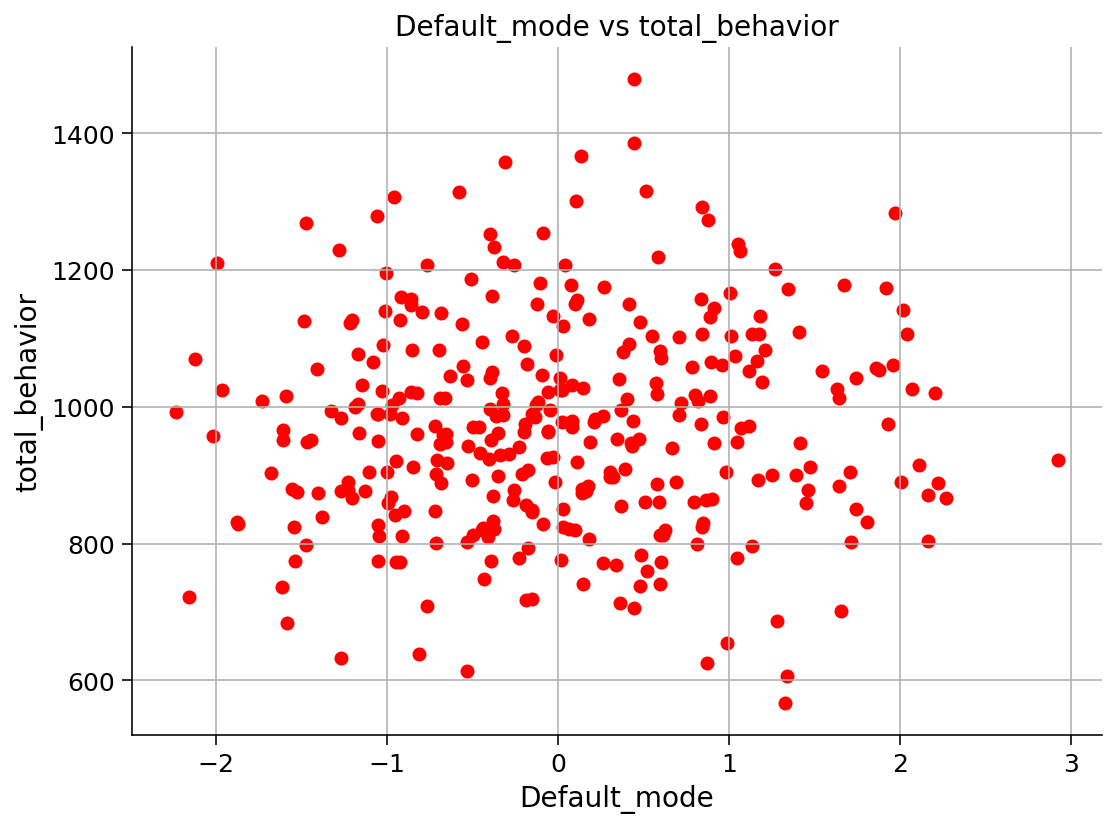

In [142]:
plt.scatter(df['Default_mode'], df['total_behavior'], color='red')
plt.title('Default_mode vs total_behavior', fontsize=14)
plt.xlabel('Default_mode', fontsize=14)
plt.ylabel('total_behavior', fontsize=14)
plt.grid(True)
plt.show()

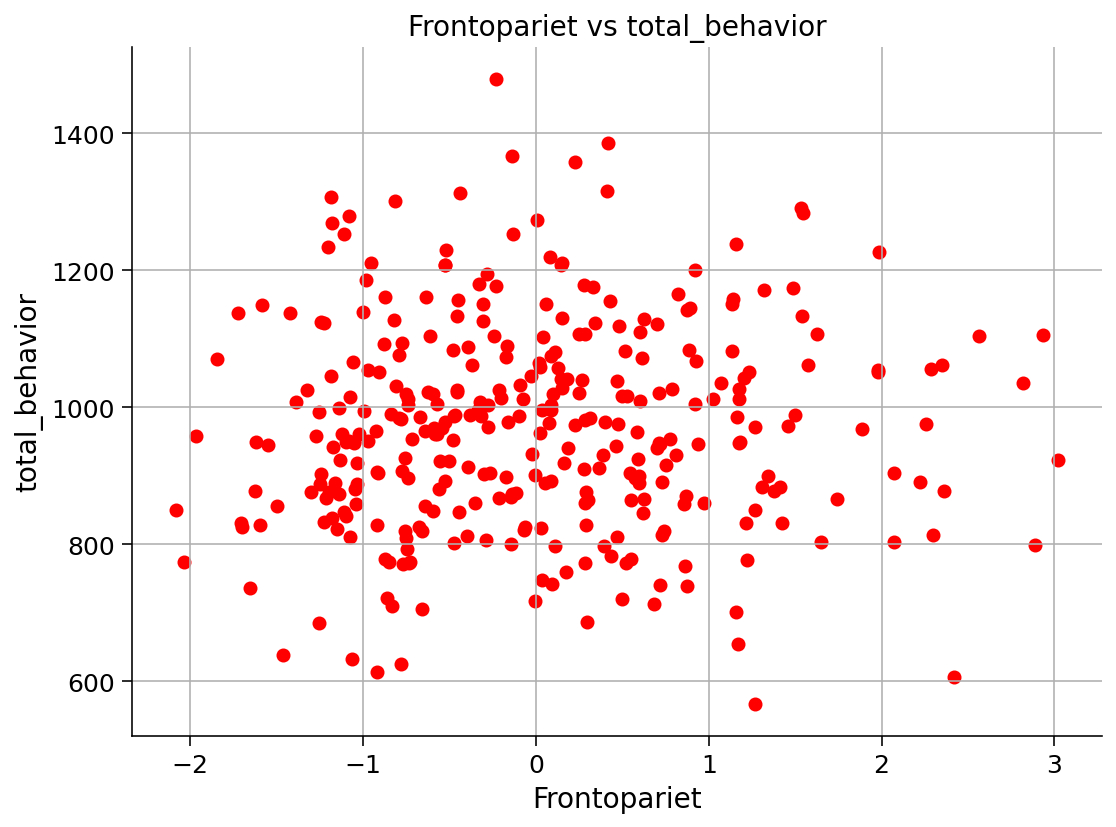

In [143]:
plt.scatter(df['Frontopariet'], df['total_behavior'], color='red')
plt.title('Frontopariet vs total_behavior', fontsize=14)
plt.xlabel('Frontopariet', fontsize=14)
plt.ylabel('total_behavior', fontsize=14)
plt.grid(True)
plt.show()

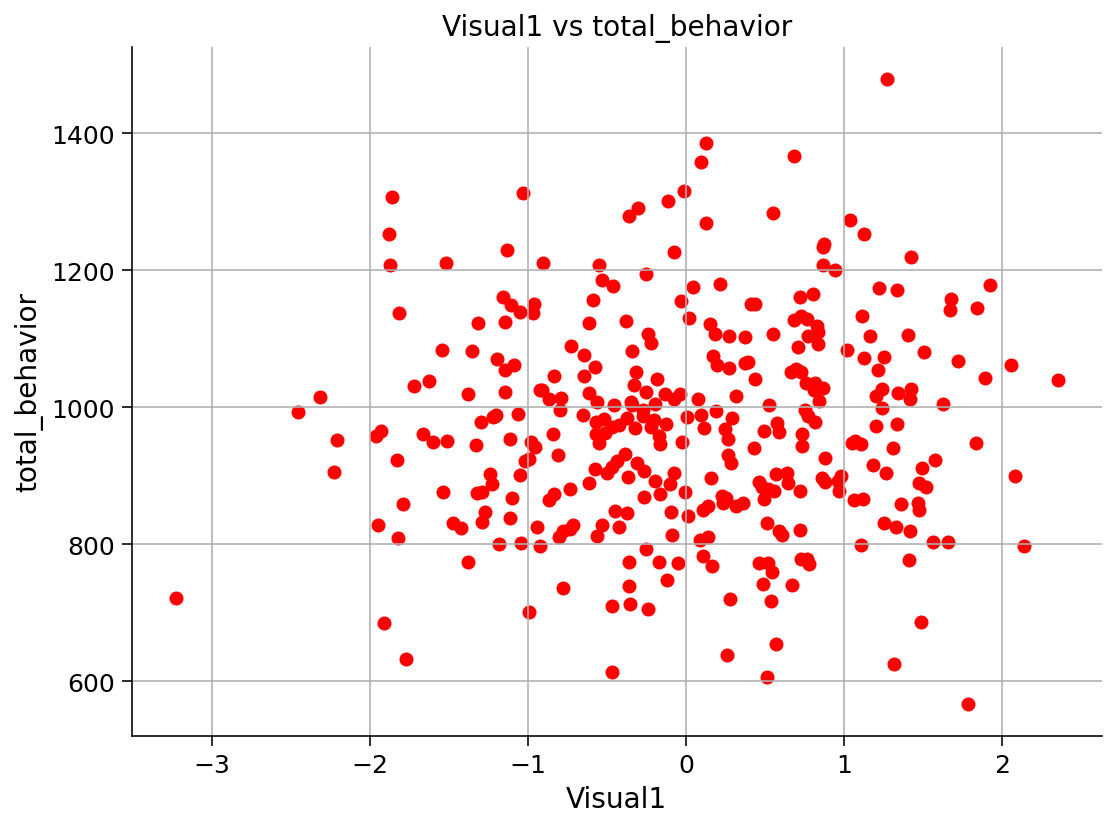

In [144]:
plt.scatter(df['Visual1'], df['total_behavior'], color='red')
plt.title('Visual1 vs total_behavior', fontsize=14)
plt.xlabel('Visual1', fontsize=14)
plt.ylabel('total_behavior', fontsize=14)
plt.grid(True)
plt.show()

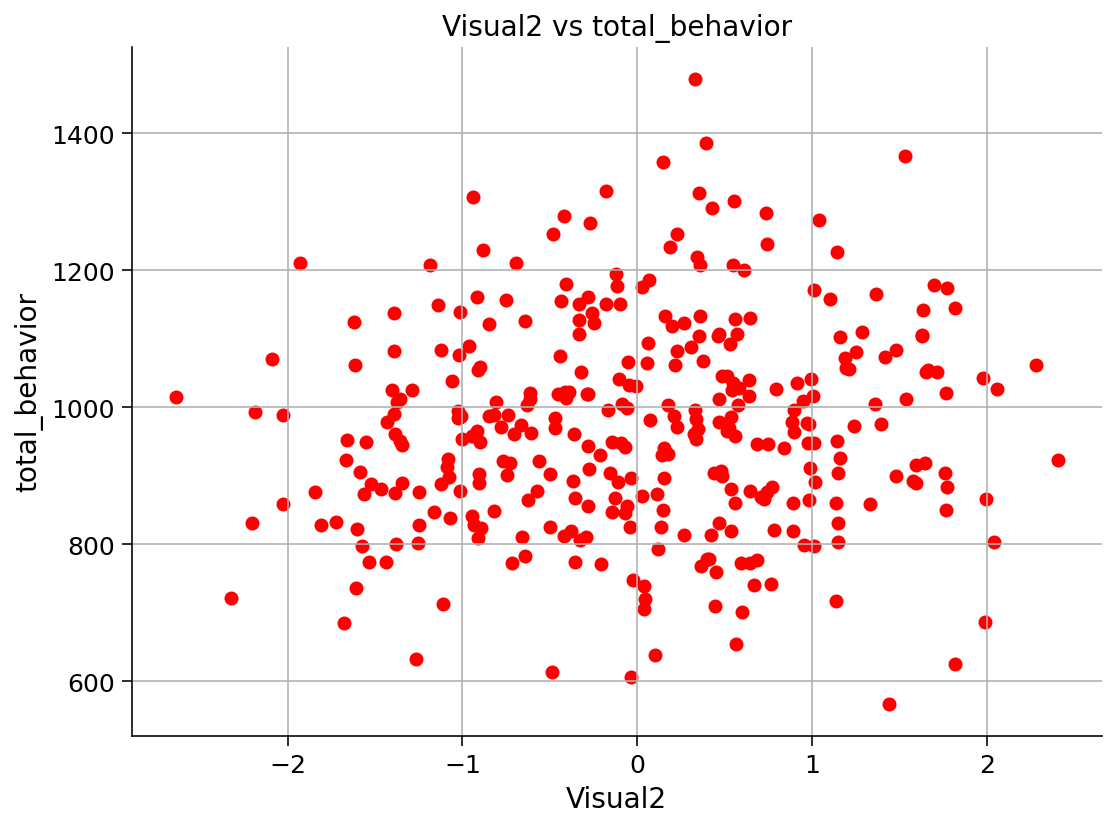

In [145]:
plt.scatter(df['Visual2'], df['total_behavior'], color='red')
plt.title('Visual2 vs total_behavior', fontsize=14)
plt.xlabel('Visual2', fontsize=14)
plt.ylabel('total_behavior', fontsize=14)
plt.grid(True)
plt.show()

In [146]:
## Fit in a linear regression model to see if there is any relationship between network and test scores.
X = df[['Default_mode','Frontopariet']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = df['total_behavior']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# prediction with sklearn
#New_Interest_Rate = 2.75
#New_Unemployment_Rate = 5.3
#print ('Predicted Stock Index Price: \n', regr.predict([[New_Interest_Rate ,New_Unemployment_Rate]]))

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 971.6200742362533
Coefficients: 
 [3.75029417 2.72336607]
                            OLS Regression Results                            
Dep. Variable:         total_behavior   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2660
Date:                Thu, 10 Dec 2020   Prob (F-statistic):              0.767
Time:                        04:16:35   Log-Likelihood:                -2164.7
No. Observations:                 336   AIC:                             4335.
Df Residuals:                     333   BIC:                             4347.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

#### we could see that frontoparietal network connectivity significantly predicts 2-back reaction time, independent of default mode and somatomotor network connectivity

In [147]:
# ## The neural network way
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(group_fc, labels, test_size=0.3)